In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
# from Transformers.NanoGPT import block_size
%matplotlib inline


In [19]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [20]:
len(words)

32033

In [21]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])
Xdev, Ydev = build_datasets(words[n1:n2])
Xte, Yte = build_datasets(words[n2:])

print(len(Xtr), len(Xdev), len(Xte))



182599 22736 22811


In [26]:
print(Xtr.size(), Ytr.size(), Xte.size(), Yte.size())

torch.Size([182599, 3]) torch.Size([182599]) torch.Size([22811, 3]) torch.Size([22811])


In [27]:
# ------------- > lets make this more cleaner

In [154]:
X.shape,  Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [102]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.rand(27, 2 , generator=g)  # look up table
W1 = torch.randn((6, 300), generator=g)  ## Layer 1
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)  # layer 2
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [103]:
sum(p.nelement() for p in parameters) # num of parameters


10281

## Forward Pass

In [104]:
for p in parameters:
    p.requires_grad = True

In [105]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [106]:
lri = []
lossi = []
stepi = []

In [114]:
epochs = 30000
for i in range(epochs):

    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    # lr = lrs[i]

    lr = 0.01
    for p in parameters:
        learning_rate = -lr
        p.data += learning_rate * p.grad
    # tracking status
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(lossi[-1])

0.3676691949367523


In [80]:
# plt.plot(lri, lossi)

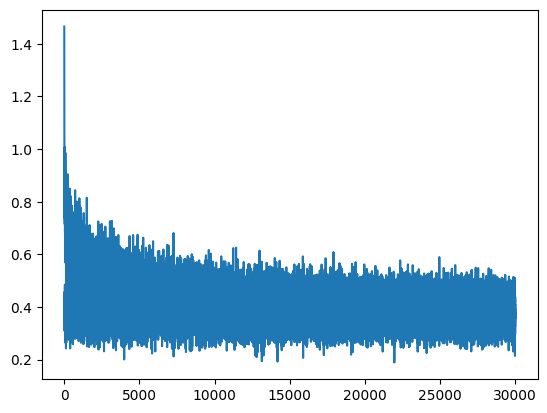

In [115]:
plt.plot(stepi, lossi)

## Overall Training loss

In [116]:
# for all training set
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.3041844367980957


In [117]:
# dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3123433589935303

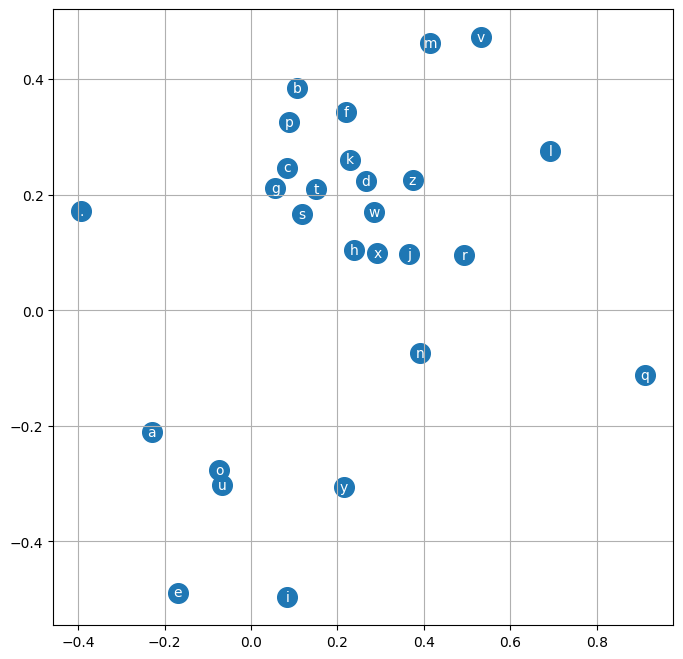

In [118]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')